In [2]:
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [5]:
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(fname="flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
data_dir

WindowsPath('C:/Users/murat/.keras/datasets/flower_photos')

In [9]:
image_count = len(list(data_dir.glob(pattern="*/*.jpg")))
image_count

3670

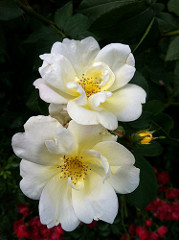

In [11]:
roses = list(data_dir.glob(pattern="roses/*"))
PIL.Image.open(str(roses[0]))

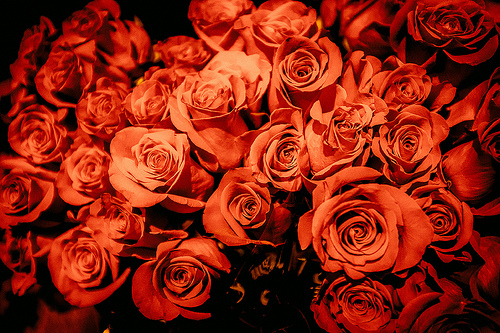

In [15]:
PIL.Image.open(str(roses[2]))

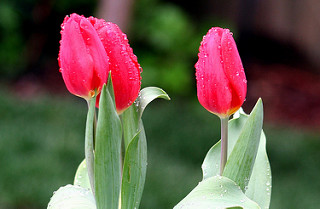

In [16]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

### Load data using a keras utility

In [17]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [22]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

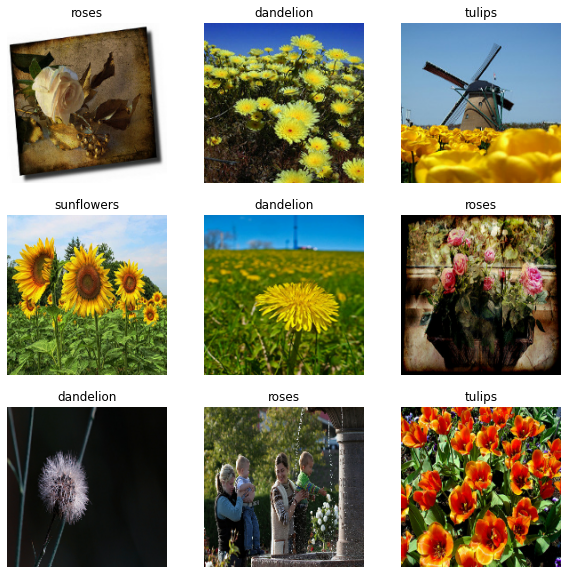

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X=images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data
#### The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [32]:
normalization_layer = layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [42]:
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=num_classes)
])

In [43]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["accuracy"]
)

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [46]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 18s 188ms/step - loss: 1.7644 - accuracy: 0.2030 - val_loss: 1.3852 - val_accuracy: 0.1703
Epoch 2/10
92/92 [==============================] - 18s 194ms/step - loss: 1.3317 - accuracy: 0.1669 - val_loss: 1.2472 - val_accuracy: 0.1676
Epoch 3/10
92/92 [==============================] - 19s 202ms/step - loss: 1.1655 - accuracy: 0.1911 - val_loss: 1.3984 - val_accuracy: 0.1975
Epoch 4/10
92/92 [==============================] - 19s 202ms/step - loss: 1.0081 - accuracy: 0.1914 - val_loss: 1.3671 - val_accuracy: 0.2439
Epoch 5/10
92/92 [==============================] - 19s 202ms/step - loss: 0.8799 - accuracy: 0.1972 - val_loss: 1.3199 - val_accuracy: 0.2670
Epoch 6/10
92/92 [==============================] - 19s 204ms/step - loss: 0.6946 - accuracy: 0.1989 - val_loss: 1.2704 - val_accuracy: 0.1649
Epoch 7/10
92/92 [==============================] - 19s 204ms/step - loss: 0.5360 - accuracy: 0.1996 - val_loss: 1.2172 - val_accuracy: 0.1894

In [49]:
history.history

{'loss': [1.764435887336731,
  1.3317357301712036,
  1.1654784679412842,
  1.008086085319519,
  0.8799341917037964,
  0.6946243643760681,
  0.5360159873962402,
  0.4186079204082489,
  0.3245645761489868,
  0.2636466324329376],
 'accuracy': [0.20299728214740753,
  0.16689373552799225,
  0.19107629358768463,
  0.1914168894290924,
  0.19720707833766937,
  0.19891008734703064,
  0.1995912790298462,
  0.19891008734703064,
  0.18835149705410004,
  0.19039510190486908],
 'val_loss': [1.3852405548095703,
  1.2471550703048706,
  1.3984127044677734,
  1.3670953512191772,
  1.3199433088302612,
  1.2704013586044312,
  1.2171505689620972,
  1.3371210098266602,
  1.2747058868408203,
  1.310581922531128],
 'val_accuracy': [0.1702997237443924,
  0.1675749272108078,
  0.19754768908023834,
  0.24386921525001526,
  0.2670299708843231,
  0.1648501306772232,
  0.18937329947948456,
  0.21117165684700012,
  0.18664850294589996,
  0.21117165684700012]}

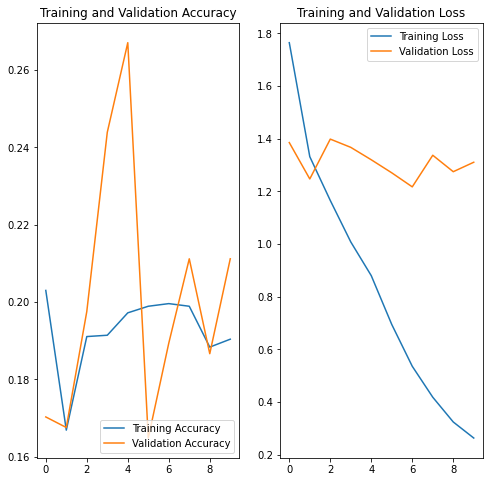

In [51]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show();

### Data Augmentation

In [56]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1)
])

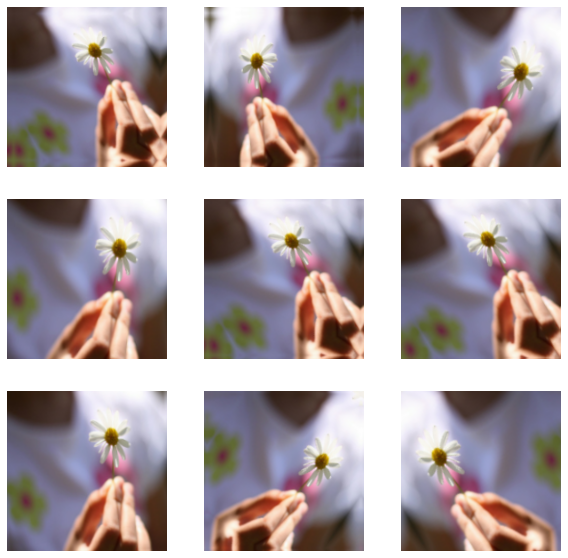

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X=augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [60]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=num_classes, name="outputs")
])

In [61]:
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [63]:
epochs = 15
history = model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 20s 210ms/step - loss: 1.7552 - accuracy: 0.1928 - val_loss: 1.8069 - val_accuracy: 0.2030
Epoch 2/15
92/92 [==============================] - 20s 220ms/step - loss: 1.3167 - accuracy: 0.1945 - val_loss: 1.1990 - val_accuracy: 0.2044
Epoch 3/15
92/92 [==============================] - 21s 232ms/step - loss: 1.2123 - accuracy: 0.2054 - val_loss: 1.2011 - val_accuracy: 0.1621
Epoch 4/15
92/92 [==============================] - 21s 233ms/step - loss: 1.1456 - accuracy: 0.2003 - val_loss: 1.1342 - val_accuracy: 0.2153
Epoch 5/15
92/92 [==============================] - 21s 231ms/step - loss: 1.1374 - accuracy: 0.1999 - val_loss: 1.4689 - val_accuracy: 0.1689
Epoch 6/15
92/92 [==============================] - 21s 233ms/step - loss: 1.1029 - accuracy: 0.1877 - val_loss: 1.0999 - val_accuracy: 0.1594
Epoch 7/15
92/92 [==============================] - 22s 239ms/step - loss: 1.0700 - accuracy: 0.1870 - val_loss: 1.0419 - val_accuracy: 0.1744

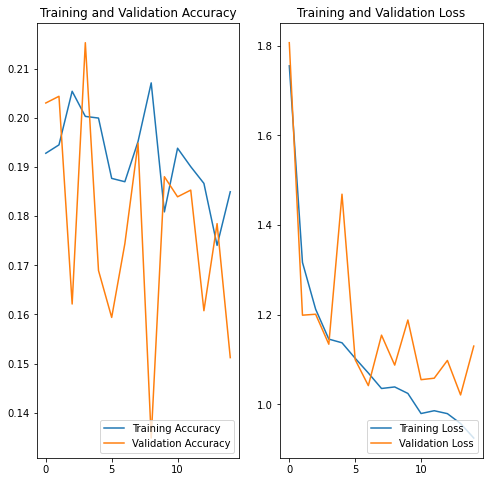

In [65]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show();

### Predict on new data
#### Use your model to classify an image that wasn't included in the training or validation sets.

In [69]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file("Red_sunflower", origin=sunflower_url)

img = tf.keras.utils.load_img(path=sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img=img)
img_array = tf.expand_dims(input=img_array, axis=0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100*np.max(score):.2f} percent confidence."
)

1/1 [==============================] - 0s 84ms/step
This image most likely belongs to daisy with a 20.42 percent confidence.


### Use Tensorflow Lite
#### Tensorflow lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

In [70]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\murat\AppData\Local\Temp\tmpuyldxp3n\assets


INFO:tensorflow:Assets written to: C:\Users\murat\AppData\Local\Temp\tmpuyldxp3n\assets


In [71]:
#  C:\Users\murat\AppData\Local\Temp\tmpuyldxp3n\assets

In [72]:
TF_MODEL_FILE_PATH = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [73]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In [74]:
classify_lite = interpreter.get_signature_runner("serving_default")
classify_lite

In [76]:
predictions_lite = classify_lite(sequential_2_input=img_array)["outputs"]
score_lite = tf.nn.softmax(predictions_lite)

In [77]:
print(f"This image most likely belongs to {class_names[np.argmax(score_lite)]}, with a {100*np.max(score_lite):.2f} percent confidence.")

This image most likely belongs to daisy, with a 20.42 percent confidence.


In [78]:
np.max(np.abs(predictions - predictions_lite))

1.9073486e-06